# Autonomous Driving Safety Predictor Using Raw Sensor Data

## Project Overview

In this project, we will build a machine learning model to predict safety-critical scenarios in autonomous driving using **raw sensor data**. We will manually engineer features from accelerometer and gyroscope readings and then train an XGBoost classifier to make predictions.

### Import Libraries

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

### Load and Inspect Raw Data

In [27]:
# Load the raw sensor data
sensor_raw = pd.read_csv('./data/sensor_raw.csv')

# Inspect the structure of the raw data
print(sensor_raw.info())
print(sensor_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Target(Class)  1114 non-null   int64  
 1   GyroX          1114 non-null   float64
 2   GyroY          1114 non-null   float64
 3   GyroZ          1114 non-null   float64
 4   AccX           1114 non-null   float64
 5   AccY           1114 non-null   float64
 6   AccZ           1114 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 61.0 KB
None
   Target(Class)     GyroX     GyroY     GyroZ      AccX      AccY      AccZ
0              1 -0.923664  3.694656  0.824427  0.162598 -0.086670 -0.969482
1              1 -0.908397  4.534351  0.832061  0.175781 -0.100586 -1.013184
2              1  0.786260  3.969466  0.587786  0.322754 -0.140381 -0.911621
3              1  0.335878  4.564885 -0.251908  0.480225 -0.226807 -0.936768
4              1  3.351145  2.694656 -0.106870  0.426025 

## Feature Engineering

To extract meaningful insights from the raw sensor data, we manually engineer features such as the mean, variance, skewness, and kurtosis for both accelerometer and gyroscope readings. These features help in capturing patterns that may indicate safety-critical scenarios.

In [46]:
# Feature engineering function
def engineer_features(df):
    features = pd.DataFrame()

    # Mean of Accelerometer and Gyroscope readings
    features['AccMeanX'] = df['AccX'].rolling(window=10).mean()
    features['AccMeanY'] = df['AccY'].rolling(window=10).mean()
    features['AccMeanZ'] = df['AccZ'].rolling(window=10).mean()
    
    features['GyroMeanX'] = df['GyroX'].rolling(window=10).mean()
    features['GyroMeanY'] = df['GyroY'].rolling(window=10).mean()
    features['GyroMeanZ'] = df['GyroZ'].rolling(window=10).mean()

    # Variance of Accelerometer and Gyroscope readings
    features['AccVarX'] = df['AccX'].rolling(window=10).var()
    features['AccVarY'] = df['AccY'].rolling(window=10).var()
    features['AccVarZ'] = df['AccZ'].rolling(window=10).var()

    features['GyroVarX'] = df['GyroX'].rolling(window=10).var()
    features['GyroVarY'] = df['GyroY'].rolling(window=10).var()
    features['GyroVarZ'] = df['GyroZ'].rolling(window=10).var()

    return features

# Apply feature engineering to the raw sensor data
sensor_features = engineer_features(sensor_raw)

# Drop NaN values created by rolling windows
sensor_features.dropna(inplace=True)

# Add the target variable back
sensor_features['Target'] = sensor_raw['Target(Class)'][len(sensor_raw) - len(sensor_features):].reset_index(drop=True)

# Inspect the engineered features
print(sensor_features.info())
print(sensor_features.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, 9 to 1113
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccMeanX   1105 non-null   float64
 1   AccMeanY   1105 non-null   float64
 2   AccMeanZ   1105 non-null   float64
 3   GyroMeanX  1105 non-null   float64
 4   GyroMeanY  1105 non-null   float64
 5   GyroMeanZ  1105 non-null   float64
 6   AccVarX    1105 non-null   float64
 7   AccVarY    1105 non-null   float64
 8   AccVarZ    1105 non-null   float64
 9   GyroVarX   1105 non-null   float64
 10  GyroVarY   1105 non-null   float64
 11  GyroVarZ   1105 non-null   float64
 12  Target     1096 non-null   float64
dtypes: float64(13)
memory usage: 120.9 KB
None
    AccMeanX  AccMeanY  AccMeanZ  GyroMeanX  GyroMeanY  GyroMeanZ   AccVarX  \
9   0.313843 -0.168262 -0.951318   0.035878   4.421374  -0.278626  0.013547   
10  0.315308 -0.169629 -0.954590   0.029008   4.382443  -0.291603  0.013076   
11  0.315845 

## Data Splitting

We split the dataset into features (`X`) and the target variable (`y`). The target variable indicates whether a scenario is safety-critical. Afterward, we split the data into training (80%) and testing (20%) sets.

In [47]:
# Splitting features and target
X = sensor_features.drop(columns=['Target'])
y = sensor_features['Target']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (884, 12)
X_test shape: (221, 12)
y_train shape: (884,)
y_test shape: (221,)


## Adjusting Class Labels

The target labels must start from `0` for compatibility with the XGBoost model. If the labels start from `1`, we will shift them to ensure the correct label format.

In [49]:
# If the labels are [1, 2, 3, 4], we need to shift them to [0, 1, 2, 3]
y_train = y_train - 1
y_test = y_test - 1

# Check unique labels after the shift
print(f"Unique labels in y_train: {y_train.unique()}")
print(f"Unique labels in y_test: {y_test.unique()}")

Unique labels in y_train: [ 3.  1.  0.  2. nan]
Unique labels in y_test: [ 1.  3.  2.  0. nan]


## Handling Missing Values (NaN)

During the feature engineering process, some missing values (NaNs) may have been introduced. We remove these NaNs to ensure that the dataset is clean before training the model.

In [50]:
# Remove NaN values from y_train and the corresponding rows from X_train
nan_indices_train = y_train[y_train.isna()].index
X_train = X_train.drop(nan_indices_train)
y_train = y_train.drop(nan_indices_train)

# Remove NaN values from y_test and the corresponding rows from X_test
nan_indices_test = y_test[y_test.isna()].index
X_test = X_test.drop(nan_indices_test)
y_test = y_test.drop(nan_indices_test)

# Reset indices after dropping NaN values to avoid future misalignment
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Check the new unique labels after removing NaN
print(f"Unique labels in y_train after NaN removal: {y_train.unique()}")
print(f"Unique labels in y_test after NaN removal: {y_test.unique()}")

# Check the shapes of X_train, y_train, X_test, and y_test
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Unique labels in y_train after NaN removal: [3. 1. 0. 2.]
Unique labels in y_test after NaN removal: [1. 3. 2. 0.]
X_train shape: (876, 12)
y_train shape: (876,)
X_test shape: (220, 12)
y_test shape: (220,)


## Model Training

We train the XGBoost classifier on the training dataset. This involves fitting the model on the feature set (`X_train`) and target labels (`y_train`). After training, we will evaluate the model's performance on the test dataset.

## Model Evaluation

After training the model, we evaluate its performance on the test set. Key metrics include **accuracy**, **precision**, **recall**, and **F1-score** for each class.

In [51]:
# Initialize and train the XGBoost model
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate a detailed classification report
print(classification_report(y_test, y_pred))


Test Accuracy: 0.97
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        49
         1.0       0.97      0.98      0.97        59
         2.0       0.98      0.93      0.96        70
         3.0       1.00      1.00      1.00        42

    accuracy                           0.97       220
   macro avg       0.97      0.98      0.98       220
weighted avg       0.97      0.97      0.97       220



## Model Results

The model achieved excellent results, with the following key performance metrics:
- **Test Accuracy**: 97%
- **Class-wise Performance**:
  - **Class 0**: Precision (0.94), Recall (1.00), F1-Score (0.97)
  - **Class 1**: Precision (0.97), Recall (0.98), F1-Score (0.97)
  - **Class 2**: Precision (0.98), Recall (0.93), F1-Score (0.96)
  - **Class 3**: Precision (1.00), Recall (1.00), F1-Score (1.00)

These results demonstrate that the model can accurately predict safety-critical scenarios.

## Next Steps for Improvement

To further enhance the model’s performance and gain deeper insights, we propose the following next steps:

1. **Hyperparameter Tuning**:
   Use `RandomizedSearchCV` or `GridSearchCV` to optimize the model's hyperparameters for potentially better accuracy.
   
2. **Feature Importance**:
   Visualize feature importance to understand which features contribute the most to model predictions.
   
3. **Confusion Matrix**:
   Generate a confusion matrix to visually assess how well the model performed in predicting each class.
   
4. **Model Deployment**:
   Save the trained model for deployment or future use.


## Hyperparameter Tuning

We can fine-tune the model by adjusting key hyperparameters such as `n_estimators`, `max_depth`, `learning_rate`, and `subsample`. This allows the model to perform optimally for the dataset.

In [52]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                   n_iter=25, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.2f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2}
Best cross-validation accuracy: 0.96


## Feature Importance

XGBoost provides a method to visualize the importance of each feature. This allows us to identify which features contribute the most to the model's predictions.

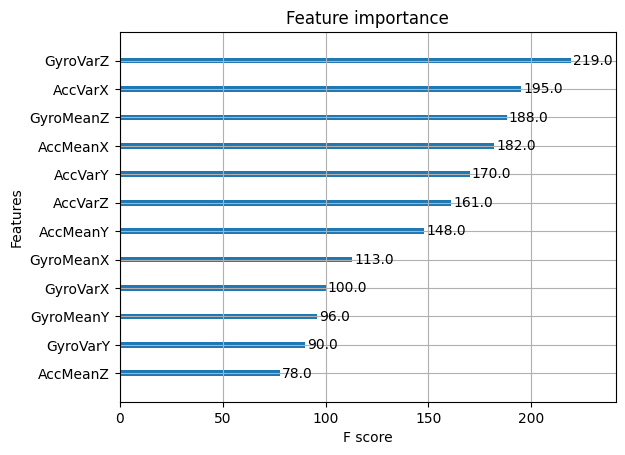

In [53]:
xgb.plot_importance(model)
plt.show()

## Confusion Matrix

A confusion matrix provides a visual breakdown of how many instances the model correctly predicted for each class and where it made mistakes. This helps in understanding the model’s strengths and weaknesses for each class.

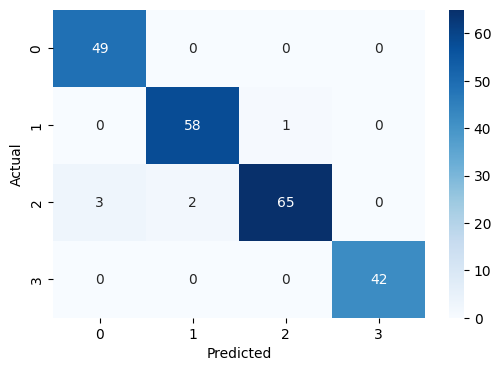

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()